In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, ResNet18_Weights
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [12]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = CIFAR10(root='./data', train=False, download=True, transform=transform)

In [13]:
targets = train_data.targets
class_counts = np.array([targets.count(i) for i in range(10)])
weights = 1. / class_counts
samples_weight = [weights[t] for t in targets]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

train_loader = DataLoader(train_data, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [14]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

In [15]:
class_weights = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [16]:
EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {running_loss:.3f} - Acc: {acc:.2f}%")

Epoch 1/5 - Loss: 1182.082 - Acc: 74.49%
Epoch 2/5 - Loss: 1019.019 - Acc: 77.44%
Epoch 3/5 - Loss: 971.223 - Acc: 78.69%
Epoch 4/5 - Loss: 980.879 - Acc: 78.47%
Epoch 5/5 - Loss: 949.206 - Acc: 79.25%


In [17]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\nTest Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 80.40%


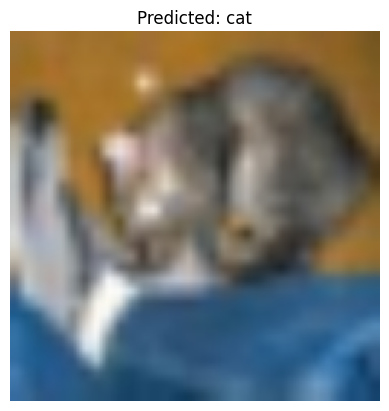

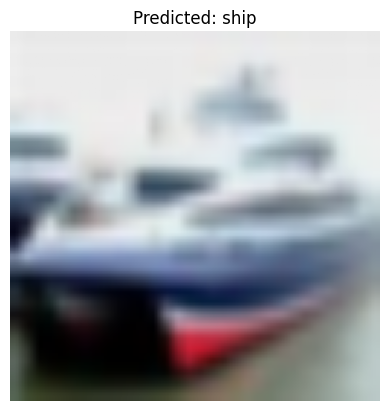

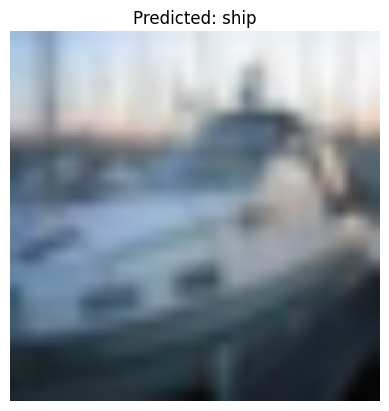

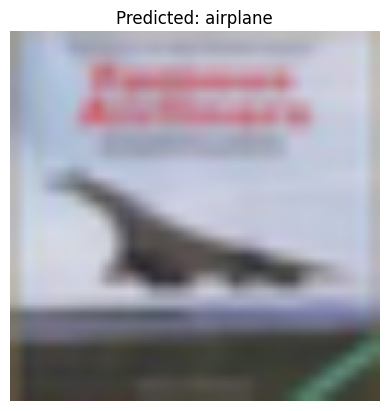

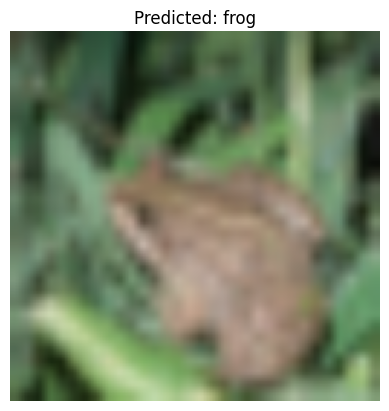

In [18]:
classes = train_data.classes

dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

# Show 5 predictions
for i in range(5):
    img = images[i] / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"Predicted: {classes[preds[i]]}")
    plt.axis('off')
    plt.show()